In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from icd9cms.icd9 import search

In [2]:
pna_df = pd.read_csv("cleaned_data_of_pneumonia_patients 1.csv")

pna_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10056 entries, 0 to 10055
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SUBJECT_ID         10056 non-null  int64  
 1   HADM_ID            10056 non-null  int64  
 2   ICD9_CODE_HISTORY  10056 non-null  object 
 3   Pneumonia          10056 non-null  int64  
 4   GENDER             10056 non-null  object 
 5   ADMISSION_TYPE     10056 non-null  object 
 6   ETHNICITY          10056 non-null  object 
 7   ADMITTIME          10056 non-null  object 
 8   DOB                10056 non-null  object 
 9   age_at_admission   9607 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 785.8+ KB


In [3]:
# ICD9 to dummies
pna_df['ICD9_CODE_HISTORY'] = pna_df['ICD9_CODE_HISTORY'].apply(lambda x: eval(x) if isinstance(x, str) else [])

icd9_dummies = pna_df['ICD9_CODE_HISTORY'].str.join('|').str.get_dummies()

pna_df = pd.concat([pna_df.drop(columns=['ICD9_CODE_HISTORY']), icd9_dummies], axis=1)

In [4]:
# pna_df['age_at_admission'] = pna_df['age_at_admission'].apply(lambda x: eval(x) if isinstance(x, str) else [])

# age_dummies = pna_df['age_at_admission'].str.join('|').str.get_dummies()

# pna_df = pd.concat([pna_df.drop(columns=['age_at_admission']), age_dummies], axis=1)

In [5]:
# One-hot encode other categorical variables
pna_df = pd.get_dummies(pna_df, columns=['GENDER', 'ADMISSION_TYPE', 'ETHNICITY'], drop_first=True)

# Handle missing values
pna_df = pna_df.dropna()  

# Ready for XGBoost
X = pna_df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DOB','Pneumonia'])
y = pna_df['Pneumonia']

In [6]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Train an optimized XGBoost classifier with reduced complexity
xgb_model_optimized = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=50,  # Reduced from 100 to speed up training
    max_depth=3,  # Reduced depth for efficiency
    learning_rate=0.1,  # Balanced learning rate
    subsample=0.8,  # Use 80% of data per boosting round
    colsample_bytree=0.8  # Use 80% of features per tree
)

# Train the model
xgb_model_optimized.fit(X_train, y_train)

# Predict on test set
y_pred_xgb_optimized = xgb_model_optimized.predict(X_test)

# Evaluate model performance
accuracy_xgb_optimized = accuracy_score(y_test, y_pred_xgb_optimized)
accuracy_xgb_matrix = confusion_matrix(y_test, y_pred_xgb_optimized)
report_xgb_optimized = classification_report(y_test, y_pred_xgb_optimized)

print(accuracy_xgb_optimized)
print(accuracy_xgb_matrix)
print(report_xgb_optimized)

0.8605619146722164
[[942 197]
 [ 71 712]]
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1139
           1       0.78      0.91      0.84       783

    accuracy                           0.86      1922
   macro avg       0.86      0.87      0.86      1922
weighted avg       0.87      0.86      0.86      1922



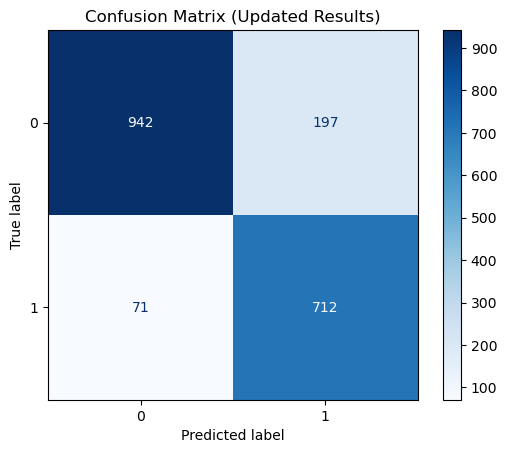

In [8]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb_optimized)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Updated Results)')
plt.grid(False)
plt.show()

In [9]:
# Download ICD-9 reference table
icd9_df = pd.read_csv('icd-9-comparison-excel-file.csv')

icd9_df = icd9_df[["ICD9", "Description"]].dropna()
icd9_df["ICD9"] = icd9_df["ICD9"].astype(str).str.strip()

# Format ICD9 codes to match model's feature format
def format_code(code):
    code = str(code)
    return code.replace(".", "").strip() if "." in code else code.strip()

icd9_df["formatted_code"] = icd9_df["ICD9"].apply(format_code)

icd9_df

,ICD9,Description,formatted_code
0,10,Cholera d/t vib cholerae,10
1,11,Cholera d/t vib el tor,11
2,19,Cholera NOS,19
3,20,Typhoid fever,20
4,21,Paratyphoid fever a,21
...,...,...,...
14568,V9129,Quad gest-plac/sac undet,V9129
14569,V9190,Mult gest-plac/sac NOS,V9190
14570,V9191,Mult gest 2+ monochr NEC,V9191
14571,V9192,Mult gest 2+ monoamn NEC,V9192


In [10]:
# import matplotlib.pyplot as plt
# import numpy as np
# from icd9cms.icd9 import search

# # Get feature importance for XGBoost (Top 50 features)
# top_n = 20  # Number of top features

# xgb_feature_importance = xgb_model_optimized.feature_importances_
# xgb_sorted_idx = np.argsort(xgb_feature_importance)[::-1]
# xgb_top_features = X.columns[xgb_sorted_idx][:top_n]  # Top 50 features
# xgb_top_importance = xgb_feature_importance[xgb_sorted_idx][:top_n]

# # Create a DataFrame for feature importance
# xgb_feature_importance_df = pd.DataFrame({
#     "Feature": xgb_top_features,
#     "Importance": xgb_top_importance
# })

# print(xgb_feature_importance_df)


In [11]:
# # Sort from highest to lowest importance (for top-down plot)
# #lr_feature_importance = lr_feature_importance.sort_values(by="Importance", ascending=True)

# plt.figure(figsize=(10, 8))
# sns.barplot(
#     x="Importance",
#     y="Feature",
#     data=xgb_feature_importance_df,
#     palette="Greens_r"
# )
# plt.xlabel("Feature Importance (|Coefficient|)")
# plt.ylabel("Feature Name")
# plt.title("Top 20 Important Features - XGBoost")
# plt.tight_layout()
# plt.show()

In [12]:
# Now prepare your model's top features
top_n = 20
importances = xgb_model_optimized.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

top_features = X.columns[sorted_idx][:top_n]
top_importances = importances[sorted_idx][:top_n]

df_top_xgb = pd.DataFrame({
    "Feature": top_features,
    "Importance": top_importances
})

# Map feature codes to ICD-9 descriptions
df_top_xgb["Description"] = df_top_xgb["Feature"].apply(
    lambda x: icd9_df.loc[icd9_df["formatted_code"] == x, "Description"].values[0]
    if x in icd9_df["formatted_code"].values else x
)

# Display
print(df_top_xgb)

                     Feature  Importance               Description
0                       4019    0.098836          Hypertension NOS
1     ADMISSION_TYPE_NEWBORN    0.097432    ADMISSION_TYPE_NEWBORN
2           age_at_admission    0.066429          age_at_admission
3   ADMISSION_TYPE_EMERGENCY    0.057937  ADMISSION_TYPE_EMERGENCY
4                      41401    0.056226  Crnry athrscl natve vssl
5                      25000    0.035695  DMII wo cmp nt st uncntr
6                       2449    0.035424        Hypothyroidism NOS
7                      42731    0.033604       Atrial fibrillation
8                       2859    0.033554                Anemia NOS
9                       2720    0.026623   Pure hypercholesterolem
10                      4280    0.025085                   CHF NOS
11                     40391    0.024293    Hyp kid NOS w cr kid V
12                       311    0.022217    Cutaneous mycobacteria
13                      3051    0.021732      Tobacco use diso

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine Feature code and Description into one label
df_top_xgb["Label"] = df_top_xgb.apply(
    lambda row: f"{row['Feature']} - {row['Description']}", axis=1
)

# Sort again to keep order from highest importance to lowest
df_top_xgb = df_top_xgb.sort_values(by="Importance", ascending=False)  # Ascending for horizontal bar plot

# # Plot with Seaborn
# plt.figure(figsize=(10, 8))
# sns.barplot(
#     x="Importance",
#     y="Label",
#     data=df_top_xgb,
#     palette="viridis"
# )
# plt.xlabel("Feature Importance")
# plt.ylabel("ICD-9 Code and Description")
# plt.title("Top 20 XGBoost Feature Importances")
# plt.tight_layout()
# plt.show()

             Metric     Value
0               AUC  0.940777
1       Sensitivity  0.925415
2       Specificity  0.814828
3               PPV  0.774642
4               NPV  0.940771
5  AUC 95% CI Lower  0.936304
6  AUC 95% CI Upper  0.945592


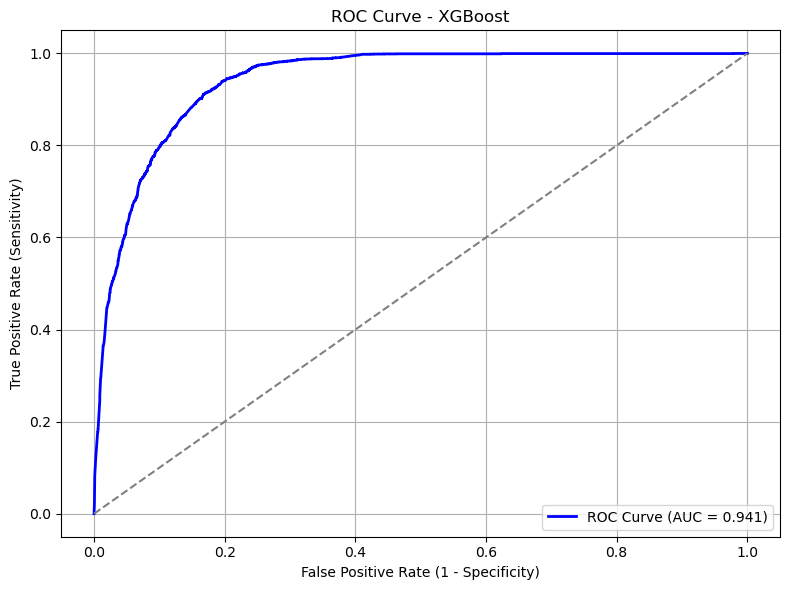

In [14]:
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, confusion_matrix
import scipy.stats as st


# Define stratified k-fold cross-validation (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated predictions
y_prob_xgb = cross_val_predict(xgb_model_optimized, X, y, cv=cv, method="predict_proba")[:, 1]  # Probability of class 1
y_pred_xgb_cv = cross_val_predict(xgb_model_optimized, X, y, cv=cv)

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(y, y_prob_xgb)
roc_auc = auc(fpr, tpr)

# Compute Sensitivity (Recall) and Specificity
tn, fp, fn, tp = confusion_matrix(y, y_pred_xgb_cv).ravel()
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)

# Compute Positive Predictive Value (PPV) and Negative Predictive Value (NPV)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

# Compute 95% Confidence Interval for AUC
auc_scores = cross_val_score(xgb_model_optimized, X, y, cv=cv, scoring='roc_auc')
ci_95 = st.t.interval(0.95, len(auc_scores) - 1, loc=np.mean(auc_scores), scale=st.sem(auc_scores))

# Display results
results = {
    "Metric": ["AUC", "Sensitivity", "Specificity", "PPV", "NPV", "AUC 95% CI Lower", "AUC 95% CI Upper"],
    "Value": [roc_auc, sensitivity, specificity, ppv, npv, ci_95[0], ci_95[1]]
}

# Convert to DataFrame and display results
results_df = pd.DataFrame(results)
print(results_df)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
fold_fprs = []
fold_tprs = []
fold_aucs = []

for i, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb_model_optimized.fit(X_train, y_train)
    y_proba = xgb_model_optimized.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    fold_fprs.append(fpr)
    fold_tprs.append(tpr)
    fold_aucs.append(auc_score)

    print(f"Fold {i} AUC: {auc_score:.3f}")


Fold 1 AUC: 0.944
Fold 2 AUC: 0.945
Fold 3 AUC: 0.942
Fold 4 AUC: 0.938
Fold 5 AUC: 0.937


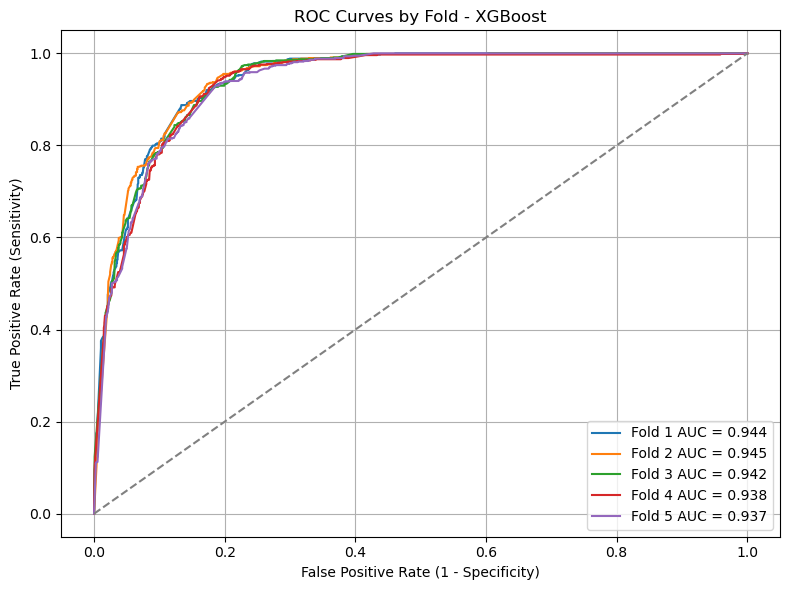

In [16]:
plt.figure(figsize=(8, 6))

for i in range(5):
    plt.plot(fold_fprs[i], fold_tprs[i], label=f"Fold {i+1} AUC = {fold_aucs[i]:.3f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curves by Fold - XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## CATBoost

In [17]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

In [18]:
# Initialize the CatBoost classifier with optimal parameters
cat_model = CatBoostClassifier(
    iterations=500,       # Number of boosting rounds
    depth=6,              # Tree depth
    learning_rate=0.1,    # Step size for optimization
    loss_function='Logloss',
    verbose=100,          # Display training progress
    random_seed=42
)

# Train the model
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)


cat_accuracy = accuracy_score(y_test, y_pred_cat)
cat_accuracy_matrix = confusion_matrix(y_test, y_pred_cat)
cat_class_report = classification_report(y_test, y_pred_cat)

print(f"CatBoost Accuracy: {cat_accuracy:.4f}")
print(cat_accuracy_matrix)
print("Classification Report:\n", cat_class_report)

0:	learn: 0.6121914	total: 211ms	remaining: 1m 45s
100:	learn: 0.2162217	total: 2.25s	remaining: 8.88s
200:	learn: 0.1723179	total: 4.44s	remaining: 6.61s
300:	learn: 0.1475309	total: 6.76s	remaining: 4.47s
400:	learn: 0.1316886	total: 8.84s	remaining: 2.18s
499:	learn: 0.1184778	total: 10.9s	remaining: 0us
CatBoost Accuracy: 0.9099
[[1010  128]
 [  45  738]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      1138
           1       0.85      0.94      0.90       783

    accuracy                           0.91      1921
   macro avg       0.90      0.92      0.91      1921
weighted avg       0.91      0.91      0.91      1921



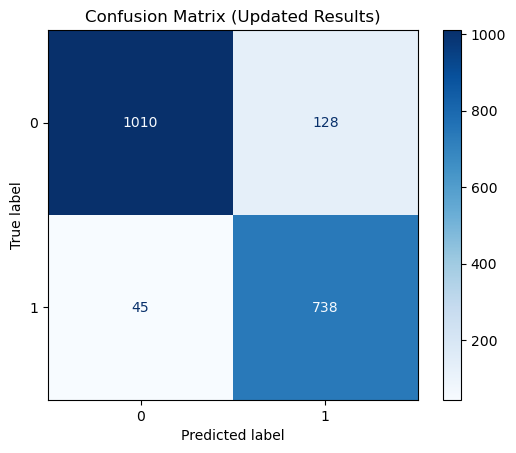

In [19]:
# Compute the confusion matrix
cm_cat = confusion_matrix(y_test, y_pred_cat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Updated Results)')
plt.grid(False)
plt.show()

In [20]:
# top_n = 20  # Number of top features

# feature_importance = cat_model.get_feature_importance()
# sorted_idx = feature_importance.argsort()[::-1]  # Get indices of top 50 features
# cat_top_features = X.columns[sorted_idx][:top_n] # Select top 50 feature names
# cat_top_importance = feature_importance[sorted_idx][:top_n] # Select top 50 importance scores

# # Create a DataFrame for feature importance
# cat_feature_importance_df = pd.DataFrame({
#     "Feature": cat_top_features,
#     "Importance": cat_top_importance
# })

# print(cat_feature_importance_df)



In [21]:
# plt.figure(figsize=(10, 12))
# sns.barplot(
#     x="Importance",
#     y="Feature",
#     data=cat_feature_importance_df,
#     palette="Greens_r"
# )
# plt.xlabel("Feature Importance (|Coefficient|)")
# plt.ylabel("Feature Name")
# plt.title("Top 20 Important Features - CATBoost")
# plt.tight_layout()
# plt.show()

In [22]:
# Now prepare your model's top features
top_n = 20
importances = cat_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

top_features = X.columns[sorted_idx][:top_n]
top_importances = importances[sorted_idx][:top_n]

df_top_cat = pd.DataFrame({
    "Feature": top_features,
    "Importance": top_importances
})

# Map feature codes to ICD-9 descriptions
df_top_cat["Description"] = df_top_cat["Feature"].apply(
    lambda x: icd9_df.loc[icd9_df["formatted_code"] == x, "Description"].values[0]
    if x in icd9_df["formatted_code"].values else x
)

# Display
print(df_top_cat)

                     Feature  Importance               Description
0                       4019   19.360717          Hypertension NOS
1                       V053   10.879461  Need prphyl vc vrl hepat
2           age_at_admission   10.066444          age_at_admission
3     ADMISSION_TYPE_NEWBORN    5.029345    ADMISSION_TYPE_NEWBORN
4                       V290    4.944021    NB obsrv suspct infect
5                       2720    4.380867   Pure hypercholesterolem
6                      25000    3.656046  DMII wo cmp nt st uncntr
7                       2859    2.935067                Anemia NOS
8                      41401    1.892709  Crnry athrscl natve vssl
9                       2449    1.516947        Hypothyroidism NOS
10                     53081    1.516203         Esophageal reflux
11                      3051    1.492096      Tobacco use disorder
12  ADMISSION_TYPE_EMERGENCY    1.456437  ADMISSION_TYPE_EMERGENCY
13                       311    1.096070    Cutaneous mycobact

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine Feature code and Description into one label
df_top_cat["Label"] = df_top_cat.apply(
    lambda row: f"{row['Feature']} - {row['Description']}", axis=1
)

# Sort again to keep order from highest importance to lowest
df_top_cat = df_top_cat.sort_values(by="Importance", ascending=False)  # Ascending for horizontal bar plot

# # Plot with Seaborn
# plt.figure(figsize=(10, 8))
# sns.barplot(
#     x="Importance",
#     y="Label",
#     data=df_top_cat,
#     palette="viridis"
# )
# plt.xlabel("Feature Importance")
# plt.ylabel("ICD-9 Code and Description")
# plt.title("Top 20 CATBoost Feature Importances")
# plt.tight_layout()
# plt.show()

In [24]:
# Get cross-validated predictions
y_prob_cat = cross_val_predict(cat_model, X, y, cv=cv, method="predict_proba")[:, 1]  # Probability of class 1
y_pred_cat_cv = cross_val_predict(cat_model, X, y, cv=cv)

# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(y, y_prob_cat)
roc_auc = auc(fpr, tpr)

# Compute Sensitivity (Recall) and Specificity
tn, fp, fn, tp = confusion_matrix(y, y_pred_cat_cv).ravel()
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)

# Compute Positive Predictive Value (PPV) and Negative Predictive Value (NPV)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

# Compute 95% Confidence Interval for AUC
auc_scores = cross_val_score(cat_model, X, y, cv=cv, scoring='roc_auc')
ci_95 = st.t.interval(0.95, len(auc_scores) - 1, loc=np.mean(auc_scores), scale=st.sem(auc_scores))

# Display results
results = {
    "Metric": ["AUC", "Sensitivity", "Specificity", "PPV", "NPV", "AUC 95% CI Lower", "AUC 95% CI Upper"],
    "Value": [roc_auc, sensitivity, specificity, ppv, npv, ci_95[0], ci_95[1]]
}

# Convert to DataFrame and display results
results_df = pd.DataFrame(results)
print(results_df)

# # Plot ROC Curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
# plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.title("ROC Curve - CatBoost")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

0:	learn: 0.6111776	total: 21.9ms	remaining: 10.9s
100:	learn: 0.2213991	total: 2.17s	remaining: 8.58s
200:	learn: 0.1783586	total: 4.38s	remaining: 6.51s
300:	learn: 0.1525506	total: 6.53s	remaining: 4.31s
400:	learn: 0.1358939	total: 8.79s	remaining: 2.17s
499:	learn: 0.1229718	total: 11s	remaining: 0us
0:	learn: 0.6119464	total: 21.6ms	remaining: 10.8s
100:	learn: 0.2162455	total: 2.36s	remaining: 9.33s
200:	learn: 0.1721973	total: 4.47s	remaining: 6.65s
300:	learn: 0.1479951	total: 6.58s	remaining: 4.35s
400:	learn: 0.1311963	total: 8.67s	remaining: 2.14s
499:	learn: 0.1182304	total: 10.7s	remaining: 0us
0:	learn: 0.6087694	total: 21.7ms	remaining: 10.8s
100:	learn: 0.2143087	total: 2.13s	remaining: 8.4s
200:	learn: 0.1714938	total: 4.2s	remaining: 6.24s
300:	learn: 0.1469781	total: 6.37s	remaining: 4.21s
400:	learn: 0.1302597	total: 8.47s	remaining: 2.09s
499:	learn: 0.1165475	total: 10.6s	remaining: 0us
0:	learn: 0.6080181	total: 20.3ms	remaining: 10.1s
100:	learn: 0.2179017	tota

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

fold_fprs = []
fold_tprs = []
fold_aucs = []

for i, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    cat_model.fit(X_train, y_train)
    y_proba = cat_model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    fold_fprs.append(fpr)
    fold_tprs.append(tpr)
    fold_aucs.append(auc_score)

    print(f"Fold {i} AUC: {auc_score:.3f}")


0:	learn: 0.6111776	total: 32.8ms	remaining: 16.4s
100:	learn: 0.2213991	total: 2.25s	remaining: 8.87s
200:	learn: 0.1783586	total: 4.42s	remaining: 6.58s
300:	learn: 0.1525506	total: 6.76s	remaining: 4.47s
400:	learn: 0.1358939	total: 9.2s	remaining: 2.27s
499:	learn: 0.1229718	total: 11.4s	remaining: 0us
Fold 1 AUC: 0.980
0:	learn: 0.6119464	total: 24.4ms	remaining: 12.2s
100:	learn: 0.2162455	total: 2.27s	remaining: 8.98s
200:	learn: 0.1721973	total: 4.57s	remaining: 6.8s
300:	learn: 0.1479951	total: 6.66s	remaining: 4.4s
400:	learn: 0.1311963	total: 8.85s	remaining: 2.18s
499:	learn: 0.1182304	total: 11s	remaining: 0us
Fold 2 AUC: 0.976
0:	learn: 0.6087694	total: 23.3ms	remaining: 11.6s
100:	learn: 0.2143087	total: 2.15s	remaining: 8.48s
200:	learn: 0.1714938	total: 4.26s	remaining: 6.33s
300:	learn: 0.1469781	total: 6.4s	remaining: 4.23s
400:	learn: 0.1302597	total: 8.6s	remaining: 2.12s
499:	learn: 0.1165475	total: 10.9s	remaining: 0us
Fold 3 AUC: 0.974
0:	learn: 0.6080181	total:

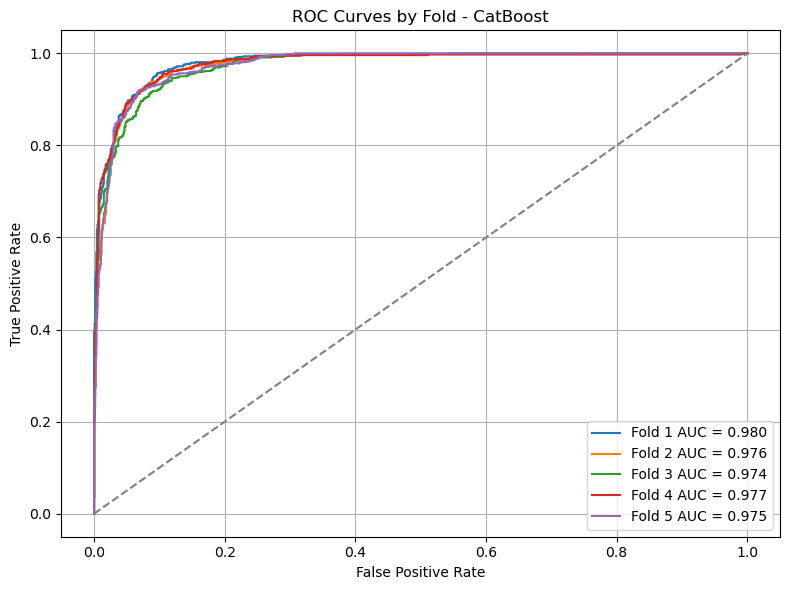

In [26]:
plt.figure(figsize=(8, 6))
for i in range(len(fold_fprs)):
    plt.plot(fold_fprs[i], fold_tprs[i], label=f"Fold {i+1} AUC = {fold_aucs[i]:.3f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Fold - CatBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
print(f"\nMean AUC across folds: {np.mean(fold_aucs):.3f} ± {np.std(fold_aucs):.3f}")



Mean AUC across folds: 0.977 ± 0.002


## AdaBoost


In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize AdaBoost classifier
ada_model = AdaBoostClassifier(
    n_estimators=100,     # Number of weak learners
    learning_rate=0.1,    # Shrinkage rate
    random_state=42
)

# Train the model
ada_model.fit(X_train, y_train)

# Predict
y_pred_ada = ada_model.predict(X_test)

# Evaluate
ada_accuracy = accuracy_score(y_test, y_pred_ada)
ada_conf_matrix = confusion_matrix(y_test, y_pred_ada)
ada_class_report = classification_report(y_test, y_pred_ada)

# Display results
print(f"AdaBoost Accuracy: {ada_accuracy:.4f}")
print("Confusion Matrix:\n", ada_conf_matrix)
print("Classification Report:\n", ada_class_report)

C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.8423
Confusion Matrix:
 [[863 275]
 [ 28 755]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.76      0.85      1138
           1       0.73      0.96      0.83       783

    accuracy                           0.84      1921
   macro avg       0.85      0.86      0.84      1921
weighted avg       0.87      0.84      0.84      1921



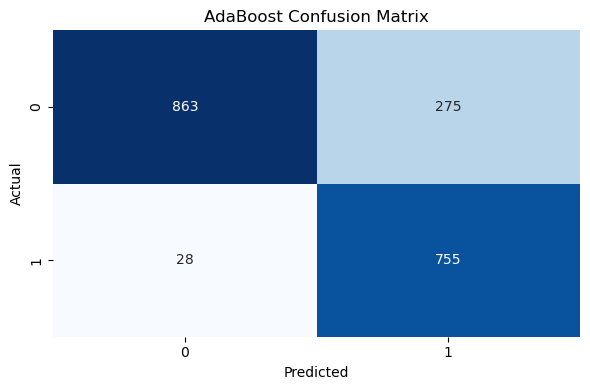

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(ada_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('AdaBoost Confusion Matrix')
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_prob_ada = ada_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_ada)
roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(6, 4))
# sns.lineplot(x=fpr, y=tpr, label=f'AUC = {roc_auc:.2f}')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('AdaBoost ROC Curve')
# plt.legend(loc='lower right')
# plt.tight_layout()
# plt.show()

In [31]:
# Now prepare your model's top features
top_n = 20
importances = ada_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

top_features = X.columns[sorted_idx][:top_n]
top_importances = importances[sorted_idx][:top_n]

df_top_ada = pd.DataFrame({
    "Feature": top_features,
    "Importance": top_importances
})

# Map feature codes to ICD-9 descriptions
df_top_ada["Description"] = df_top_ada["Feature"].apply(
    lambda x: icd9_df.loc[icd9_df["formatted_code"] == x, "Description"].values[0]
    if x in icd9_df["formatted_code"].values else x
)

# Display
print(df_top_ada)

                     Feature  Importance               Description
0           age_at_admission        0.19          age_at_admission
1                       4019        0.12          Hypertension NOS
2                      41401        0.08  Crnry athrscl natve vssl
3                      42731        0.06       Atrial fibrillation
4                       2765        0.05      Volume depletion NOS
5                      25000        0.05  DMII wo cmp nt st uncntr
6                       2720        0.05   Pure hypercholesterolem
7                       2449        0.04        Hypothyroidism NOS
8                      53081        0.04         Esophageal reflux
9                       2859        0.04                Anemia NOS
10                     51881        0.03  Acute respiratry failure
11                      2762        0.02                  Acidosis
12                     V4581        0.02      Aortocoronary bypass
13  ADMISSION_TYPE_EMERGENCY        0.02  ADMISSION_TYPE_EMERG

In [32]:
# # Extract feature importances
# feature_importance = ada_model.feature_importances_
# top_n = 20  # Top N features

# # Create DataFrame
# importances_df = pd.DataFrame({
#     "Feature": X.columns,
#     "Importance": feature_importance
# }).sort_values(by="Importance", ascending=False).head(top_n)

# Combine Feature code and Description into one label
df_top_ada["Label"] = df_top_ada.apply(
    lambda row: f"{row['Feature']} - {row['Description']}", axis=1
)

# Sort again to keep order from highest importance to lowest
df_top_ada = df_top_ada.sort_values(by="Importance", ascending=False)  # Ascending for horizontal bar plot


# # Plot with Seaborn
# plt.figure(figsize=(10, 8))
# sns.barplot(
#     x="Importance",
#     y="Label",
#     data=df_top_ada,
#     palette="viridis"
# )
# plt.xlabel("Feature Importance")
# plt.ylabel("ICD-9 Code and Description")
# plt.title("Top 20 AdaBoost Feature Importances")
# plt.tight_layout()
# plt.show()


In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from scipy.stats import sem, t

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred_cv = cross_val_predict(ada_model, X, y, cv=cv)
y_prob_cv = cross_val_predict(ada_model, X, y, cv=cv, method="predict_proba")[:, 1]

# AUC and CI
auc_scores = cross_val_score(ada_model, X, y, cv=cv, scoring='roc_auc')
ci_lower, ci_upper = t.interval(0.95, len(auc_scores) - 1, loc=np.mean(auc_scores), scale=sem(auc_scores))

# Confusion matrix metrics
tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

# Output
print(f"AUC: {np.mean(auc_scores):.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {npv:.4f}")
print(f"95% CI for AUC: ({ci_lower:.4f}, {ci_upper:.4f})")

C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anacond

AUC: 0.9414
Sensitivity: 0.9640
Specificity: 0.7846
PPV: 0.7548
NPV: 0.9694
95% CI for AUC: (0.9381, 0.9447)


In [34]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

fold_fprs = []
fold_tprs = []
fold_aucs = []

for i, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ada_model.fit(X_train, y_train)
    y_proba = ada_model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    fold_fprs.append(fpr)
    fold_tprs.append(tpr)
    fold_aucs.append(auc_score)

    print(f"Fold {i} AUC: {auc_score:.3f}")

C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 1 AUC: 0.943


C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 2 AUC: 0.941


C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 3 AUC: 0.945


C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 4 AUC: 0.939


C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fold 5 AUC: 0.939


C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anacond

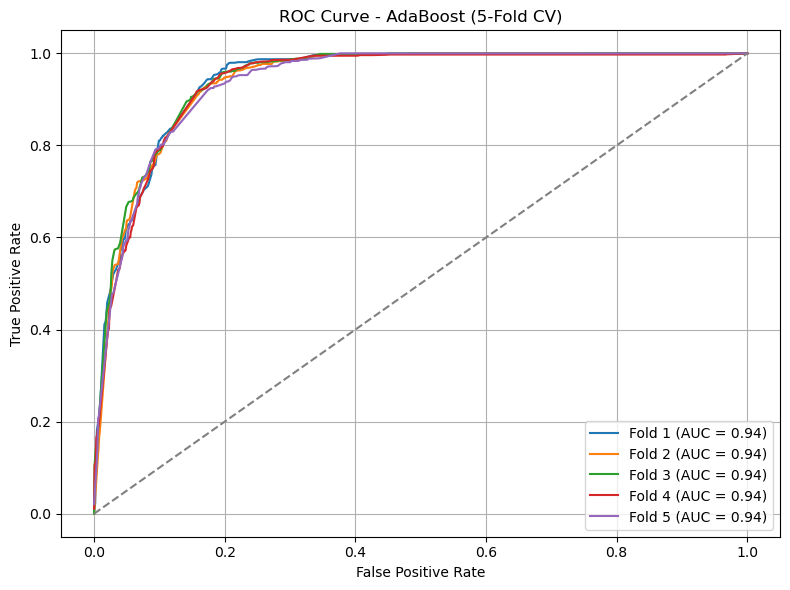

In [35]:
# ROC Curve for Each Fold in 5-Fold Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(8, 6))

for i, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit and predict
    ada_model.fit(X_train_cv, y_train_cv)
    y_prob_fold = ada_model.predict_proba(X_test_cv)[:, 1]
    
    # ROC
    fpr, tpr, _ = roc_curve(y_test_cv, y_prob_fold)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    sns.lineplot(x=fpr, y=tpr, label=f"Fold {i} (AUC = {roc_auc:.2f})")

# Reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
print(f"\nMean AUC across folds: {np.mean(fold_aucs):.3f} ± {np.std(fold_aucs):.3f}")


Mean AUC across folds: 0.941 ± 0.002


## Ensemble model combining XGBoost, CatBoost, and AdaBoost

In [37]:
#Import and Initialize Base Models

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier

# Initialize individual models
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat_model = CatBoostClassifier(verbose=0, random_seed=42)
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

In [38]:
# Create a soft voting ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('cat', cat_model),
        ('ada', ada_model)
    ],
    voting='soft'  # 'soft' uses predicted probabilities
)

In [39]:
# Train the Ensemble Model
# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

C:\Users\PSL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:35:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_co...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000002C69BEB5BD0>),
                             ('ada',
                              AdaBoostClassifier(n_estimators=100,
                                                 random_state=42))],
                 voting='soft')

In [40]:
# Evaluate Ensemble Performance

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_confusion = confusion_matrix(y_test, y_pred_ensemble)
ensemble_report = classification_report(y_test, y_pred_ensemble)

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print("Confusion Matrix:")
print(ensemble_confusion)
print("Classification Report:")
print(ensemble_report)

Ensemble Accuracy: 0.9073
Confusion Matrix:
[[1006  132]
 [  46  737]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1138
           1       0.85      0.94      0.89       783

    accuracy                           0.91      1921
   macro avg       0.90      0.91      0.91      1921
weighted avg       0.91      0.91      0.91      1921



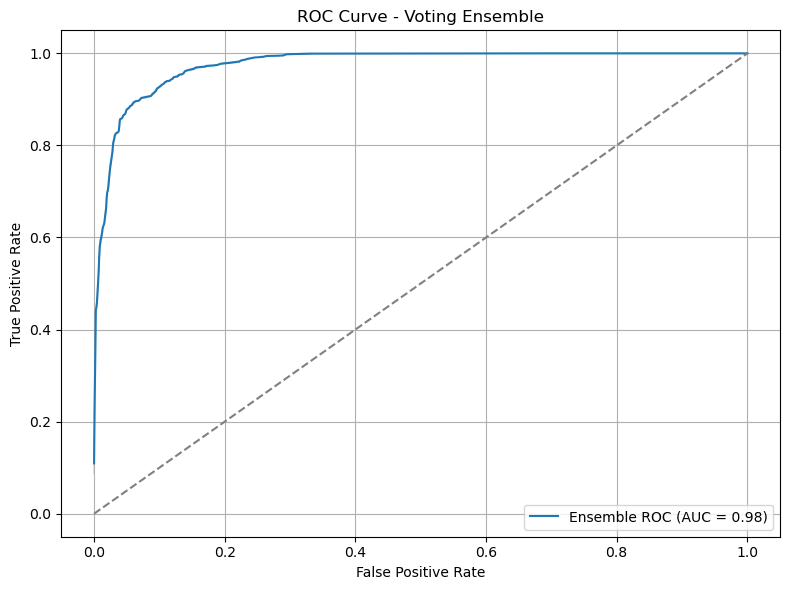

In [41]:
# Plot ROC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Get probability predictions for ROC
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_ensemble)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f"Ensemble ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Voting Ensemble")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# Define and Train the Ensemble with Cross-Validation

from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define base models
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cat_model = CatBoostClassifier(verbose=0, random_seed=42)
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Create voting classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('cat', cat_model),
        ('ada', ada_model)
    ],
    voting='soft'
)

# 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predict probabilities
y_prob_ensemble = cross_val_predict(ensemble_model, X, y, cv=cv, method='predict_proba')[:, 1]
y_pred_ensemble = (y_prob_ensemble >= 0.5).astype(int)

C:\Users\PSL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:36:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:37:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


C:\Users\PSL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:40:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\PSL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:41:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


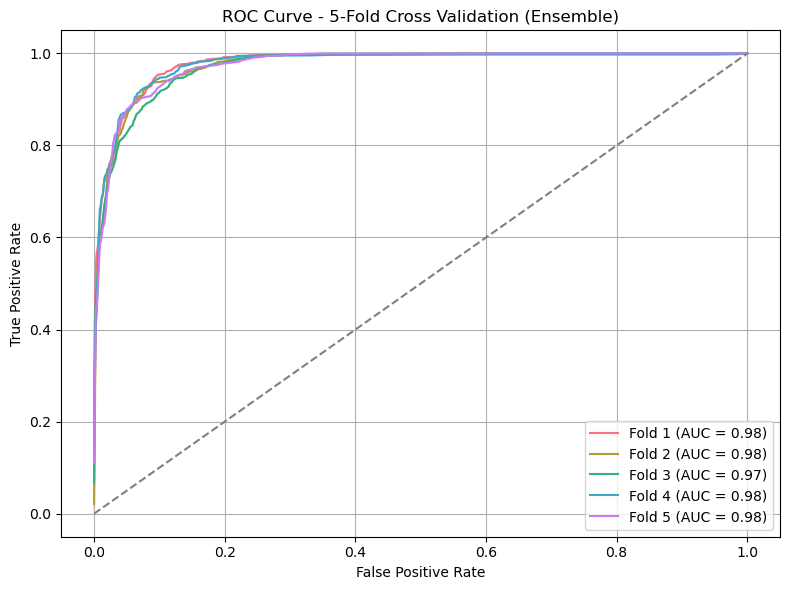

In [43]:
# ROC Curve for Each Fold

from sklearn.base import clone

plt.figure(figsize=(8, 6))
colors = sns.color_palette("husl", n_colors=5)

fold_aucs = []
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    model_clone = clone(ensemble_model)
    model_clone.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_prob = model_clone.predict_proba(X.iloc[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y.iloc[test_idx], y_prob)
    auc_score = roc_auc_score(y.iloc[test_idx], y_prob)
    fold_aucs.append(auc_score)
    sns.lineplot(x=fpr, y=tpr, label=f"Fold {i+1} (AUC = {auc_score:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - 5-Fold Cross Validation (Ensemble)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\PSL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


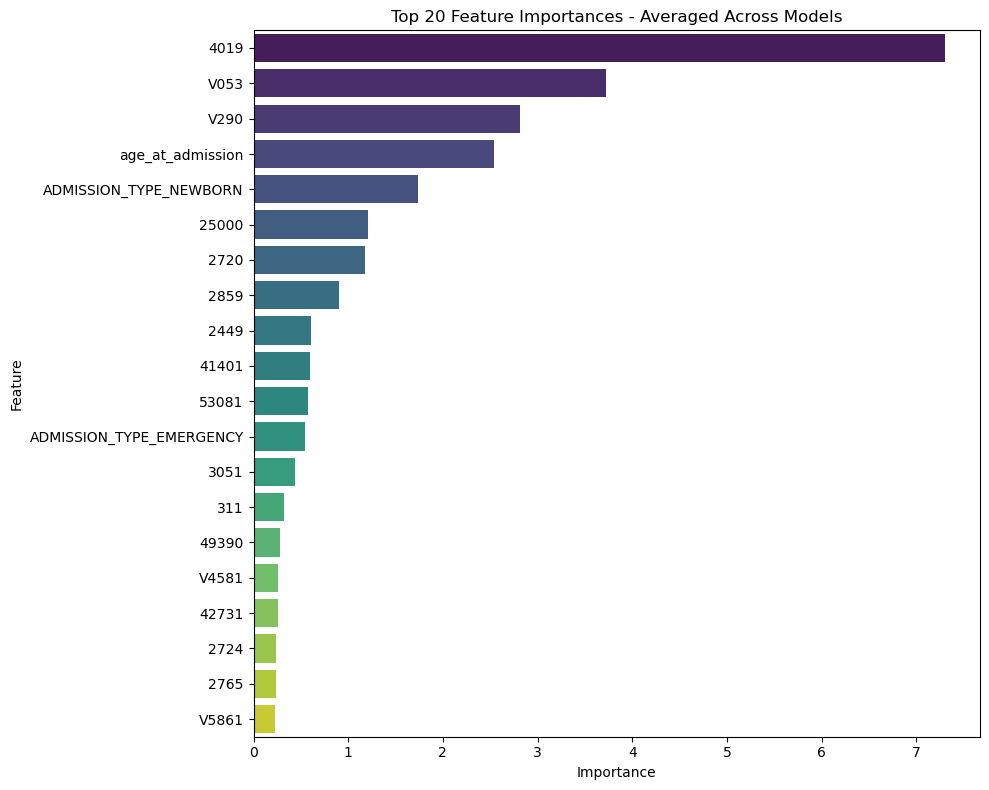

In [44]:
# # Feature Importance (Averaged)

# Get feature importances from individual models
xgb_model.fit(X, y)
cat_model.fit(X, y)
ada_model.fit(X, y)

xgb_importance = xgb_model.feature_importances_
cat_importance = cat_model.get_feature_importance()
ada_importance = ada_model.feature_importances_

# Average them
avg_importance = (xgb_importance + cat_importance + ada_importance) / 3

# Top N features
top_n = 20
sorted_idx = np.argsort(avg_importance)[::-1]
top_features = X.columns[sorted_idx][:top_n]
top_values = avg_importance[sorted_idx][:top_n]

# Create DataFrame
importances_df = pd.DataFrame({
    "Feature": top_features,
    "Importance": top_values
})

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importances_df, palette="viridis")
plt.title("Top 20 Feature Importances - Averaged Across Models")
plt.tight_layout()
plt.show()


In [45]:
# Now prepare your model's top features
top_n = 20
importances = avg_importance
sorted_idx = np.argsort(importances)[::-1]

top_features = X.columns[sorted_idx][:top_n]
top_importances = importances[sorted_idx][:top_n]

df_top_ensemble = pd.DataFrame({
    "Feature": top_features,
    "Importance": top_importances
})

# Map feature codes to ICD-9 descriptions
df_top_ensemble["Description"] = df_top_ensemble["Feature"].apply(
    lambda x: icd9_df.loc[icd9_df["formatted_code"] == x, "Description"].values[0]
    if x in icd9_df["formatted_code"].values else x
)

# Display
print(df_top_ensemble)

                     Feature  Importance               Description
0                       4019    7.306012          Hypertension NOS
1                       V053    3.718232  Need prphyl vc vrl hepat
2                       V290    2.817712    NB obsrv suspct infect
3           age_at_admission    2.536963          age_at_admission
4     ADMISSION_TYPE_NEWBORN    1.732916    ADMISSION_TYPE_NEWBORN
5                      25000    1.204117  DMII wo cmp nt st uncntr
6                       2720    1.180761   Pure hypercholesterolem
7                       2859    0.904187                Anemia NOS
8                       2449    0.610593        Hypothyroidism NOS
9                      41401    0.598710  Crnry athrscl natve vssl
10                     53081    0.574460         Esophageal reflux
11  ADMISSION_TYPE_EMERGENCY    0.543823  ADMISSION_TYPE_EMERGENCY
12                      3051    0.434968      Tobacco use disorder
13                       311    0.322644    Cutaneous mycobact

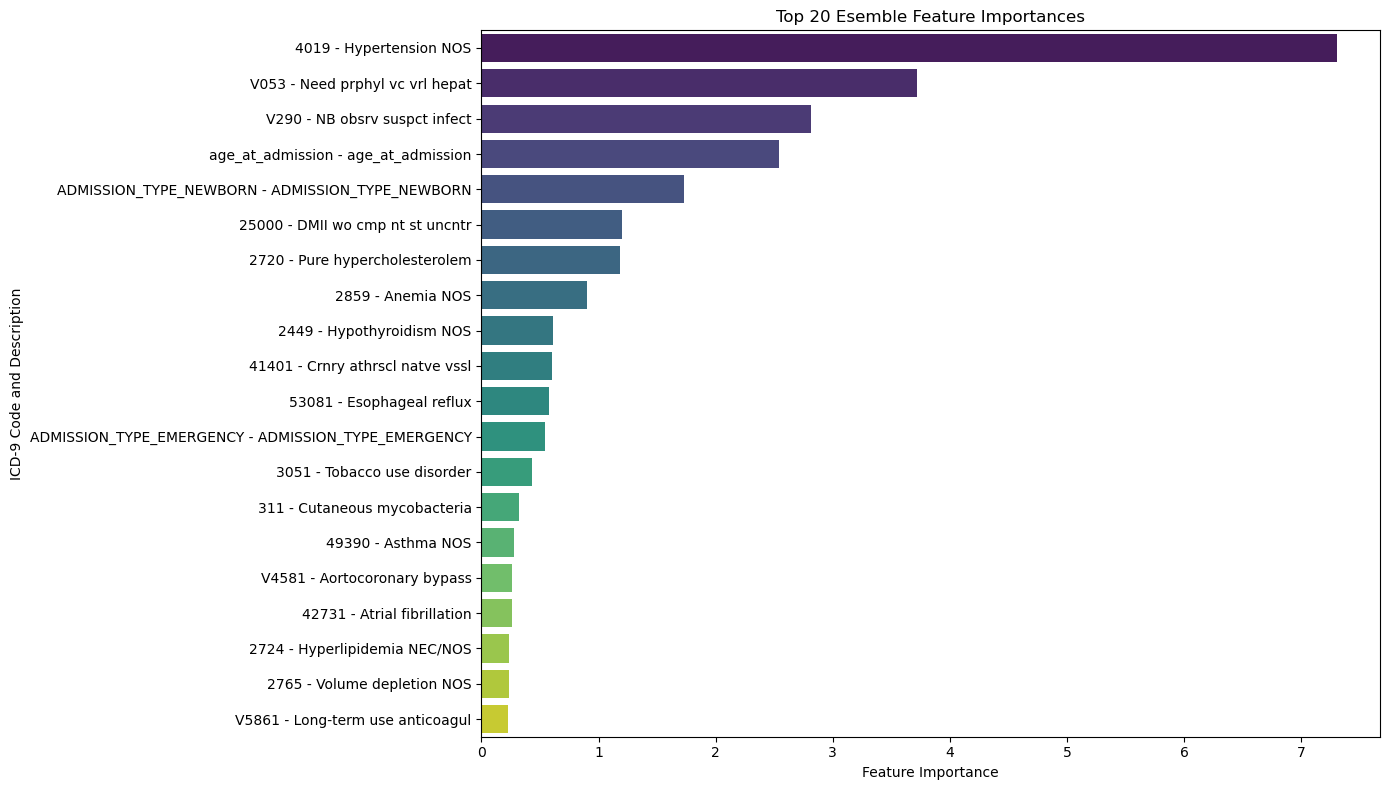

In [46]:
df_top_ensemble["Label"] = df_top_ensemble.apply(
    lambda row: f"{row['Feature']} - {row['Description']}", axis=1
)

# Sort again to keep order from highest importance to lowest
df_top_ensemble = df_top_ensemble.sort_values(by="Importance", ascending=False)  # Ascending for horizontal bar plot


# Plot with Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(
    x="Importance",
    y="Label",
    data=df_top_ensemble,
    palette="viridis"
)
plt.xlabel("Feature Importance")
plt.ylabel("ICD-9 Code and Description")
plt.title("Top 20 Esemble Feature Importances")
plt.tight_layout()
plt.show()